

This Colab notebook trains a **hybrid, logic‑regularized classifier** for symptom‑to‑disease prediction on your text dataset (`Symptom2Disease.csv`).  
It combines a **clinical language model** backbone (PubMedBERT / BioClinicalBERT) with **data‑mined token cues** as soft **logic constraints** during training.

**What you get**
- Strong **baseline** using PubMedBERT/BioClinicalBERT (Hugging Face Transformers).
- **Logic regularization**: gently nudges predictions to be **consistent** with class‑specific cues it mined from your own training data (lightweight, no external knowledge base required).
- **Selective prediction (optional)**: entropy‑based *“predict or abstain”* threshold tuned on the validation set.
- Clean **evaluation** (accuracy, macro‑F1, confusion matrix) + saved artifacts.

**References (approach & tools)**
- PubMedBERT / BiomedBERT model cards (Hugging Face).  
  - PubMed+PMC pretraining (abstract+full‑text): `microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext`.  
  - Abstract‑only: `microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract`.  
- BioClinicalBERT (trained on MIMIC clinical notes): `emilyalsentzer/Bio_ClinicalBERT`.
- DR.BENCH diagnostic‑reasoning benchmark (optional warm‑start idea).

> This notebook is **text‑only**; it does not use interactive RL questioning. It borrows the **logic regularization** idea from neural symptom‑checking research and adapts it to your static text classification setting.


In [ ]:
#@title Install libraries (HF Transformers, Datasets, scikit-learn) { display-mode: "form" }
# If running in Colab: this cell is safe to run multiple times.
!pip -q install transformers==4.42.4 datasets==2.20.0 evaluate==0.4.2 accelerate==0.33.0 scikit-learn==1.5.1 matplotlib==3.8.4

import os, math, json, random, collections, itertools
import numpy as np
import pandas as pd
from dataclasses import dataclass
import torch
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)

SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print("Torch", torch.__version__, "CUDA:", torch.cuda.is_available())


In [4]:
#@title Configuration
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
max_length = 256
train_frac = 0.8
val_frac = 0.1
batch_size = 16
epochs = 5
lr = 5e-5
weight_decay = 0.01
warmup_ratio = 0.06
alpha_logic = 0.2
p_confidence = 0.50
top_k_cues = 50
min_token_len = 3
do_selective_prediction = True
SEED = 42
print("Backbone:", model_name)


Backbone: microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext


In [5]:
#@title Load data (`Symptom2Disease.csv`)

import pandas as pd, os

candidate_paths = [
    "./Symptom2Disease.csv",
    "/content/Symptom2Disease.csv",
    "/mnt/data/Symptom2Disease.csv",
]

csv_path = None
for p in candidate_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    try:
        from google.colab import files  # type: ignore
        print("Please upload Symptom2Disease.csv")
        up = files.upload()
        csv_path = [k for k in up.keys() if k.lower().endswith(".csv")][0]
    except Exception as e:
        raise FileNotFoundError("Symptom2Disease.csv not found. Upload it or put it in the working directory.") from e

df = pd.read_csv(csv_path)
# Normalize likely auto-index column if present
for c in ("Unnamed: 0", "index"):
    if c in df.columns:
        df = df.drop(columns=[c])
assert {"text","label"}.issubset(df.columns), "CSV must have columns: text, label"

df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
print(df.head(2))
print("Rows:", len(df), "| Columns:", list(df.columns))
print("Unique labels:", df['label'].nunique())
print(df['label'].value_counts().head())


      label                                               text
0  diabetes  I have respiratory issues, especially when doi...
1   Malaria  I have a high fever, chills, and severe itchin...
Rows: 1200 | Columns: ['label', 'text']
Unique labels: 24
label
diabetes          50
Malaria           50
Typhoid           50
Pneumonia         50
Varicose Veins    50
Name: count, dtype: int64


In [6]:
#@title Train/Val/Test split
n = len(df)
n_train = int(train_frac * n)
n_val   = int(val_frac * n)
train_df = df.iloc[:n_train].reset_index(drop=True)
val_df   = df.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df  = df.iloc[n_train+n_val:].reset_index(drop=True)

labels = sorted(df["label"].unique())
label2id = {y:i for i,y in enumerate(labels)}
id2label = {i:y for y,i in label2id.items()}
print("Classes:", len(labels))


Classes: 24


In [10]:
#@title  Tokenizer & dataset objects
from dataclasses import dataclass
import pandas as pd, numpy as np, torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from dataclasses import dataclass


tok = AutoTokenizer.from_pretrained(model_name)

def encode_frame(frame):
    enc = tok(frame["text"].tolist(), truncation=True, padding=False, max_length=max_length)
    enc["labels"] = [label2id[y] for y in frame["label"].tolist()]
    return enc

train_enc = encode_frame(train_df)
val_enc   = encode_frame(val_df)
test_enc  = encode_frame(test_df)

@dataclass
class SimpleDS(torch.utils.data.Dataset):
    enc: dict
    def __len__(self): return len(self.enc["input_ids"])
    def __getitem__(self, i):
        return {k: torch.tensor(v[i]) for k,v in self.enc.items()}

train_ds = SimpleDS(train_enc)
val_ds   = SimpleDS(val_enc)
test_ds  = SimpleDS(test_enc)

collator = DataCollatorWithPadding(tokenizer=tok, padding=True)


In [12]:
#@title Mine class‑specific token cues (lightweight logic knowledge)
from collections import Counter, defaultdict

import math, os, json
from collections import Counter

special_ids = set(tok.all_special_ids)
def flatten_token_ids(enc):
    cols = ["input_ids"]
    toks = []
    for ids in enc["input_ids"]:
        toks.append([t for t in ids if t not in special_ids])
    return toks

train_token_ids = flatten_token_ids(train_enc)
train_labels = [label2id[y] for y in train_df["label"]]

# Count per class and global
class_counts = [Counter() for _ in labels]
global_counts = Counter()
for ids, y in zip(train_token_ids, train_labels):
    uniq = ids  # keep duplicates to reflect frequency
    class_counts[y].update(uniq)
    global_counts.update(uniq)

global_total = sum(global_counts.values())
class_totals = [sum(c.values()) for c in class_counts]

def token_string(tid): return tok.convert_ids_to_tokens(int(tid))

def informative_token(tid):
    s = token_string(tid)
    base = s.replace("#", "")
    return base.isalpha() and len(base) >= min_token_len

# Compute simple smoothed log-odds ratio for informativeness
def top_cues_for_class(c, k=50, alpha=0.5):
    cues = []
    for tid, cnt_c in class_counts[c].items():
        if tid in special_ids or not informative_token(tid): continue
        cnt_bg = global_counts[tid]
        # one-vs-rest background
        cnt_notc = cnt_bg - cnt_c
        total_c = class_totals[c]
        total_notc = global_total - total_c
        # add-α smoothing
        p_c = (cnt_c + alpha) / (total_c + 2*alpha)
        p_notc = (cnt_notc + alpha) / (total_notc + 2*alpha) if total_notc>0 else 1e-9
        logodds = math.log(p_c / p_notc + 1e-12)
        cues.append((logodds, tid))
    cues.sort(reverse=True)
    return [tid for _, tid in cues[:k]]

class_cues = {c: set(top_cues_for_class(c, k=top_k_cues)) for c in range(len(labels))}

# Show a preview
def preview_cues(c, m=15):
    toks = [token_string(t) for t in list(class_cues[c])[:m]]
    return toks

for c in range(min(3, len(labels))):
    print(f"Class {c} ({id2label[c]}) sample cues:", preview_cues(c))

# Save cues
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/class_cues.json", "w") as f:
    json.dump({str(c): list(map(int, sorted(list(s)))) for c,s in class_cues.items()}, f)
print("Saved artifacts/class_cues.json")


Class 0 (Acne) sample cues: ['##cing', 'breaking', '##led', 'tons', '##oke', '##urry', 'place', 'nas', 'realized', '##dle', 'black', 'latter', '##where', '##eri', 'contain']
Class 1 (Arthritis) sample cues: ['matured', 'move', 'pine', 'rock', '##ibly', '##rous', '##bles', '##inarily', 'walking', 'weakened', 'make', 'government', 'state', 'stiffness', 'without']
Class 2 (Bronchial Asthma) sample cues: ['deal', 'how', '##uses', 'dad', 'cop', 'suggest', 'generate', 'drain', 'overwhelming', 'continued', 'angry', 'manage', 'frustr', 'labor', 'contin']
Saved artifacts/class_cues.json


In [19]:
#@title Model & logic-regularized training loop — v4.55+ safe

import os, json, torch, transformers
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

print("Transformers:", transformers.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# (Optional) disable W&B logging
os.environ.setdefault("WANDB_DISABLED", "true")

# Build model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(labels)
).to(device)

# Load class cues
with open("artifacts/class_cues.json") as f:
    class_cues = {int(k): set(v) for k, v in json.load(f).items()}

# ----- logic penalty
def logic_penalty(input_ids, probs, top_idx, p_confidence=0.50):
    B = input_ids.shape[0]
    presence = torch.zeros(B, dtype=probs.dtype, device=probs.device)
    for i in range(B):
        d = int(top_idx[i])
        cues = class_cues.get(d, set())
        if not cues:
            presence[i] = 1.0
            continue
        toks = set(input_ids[i].tolist())
        presence[i] = 1.0 if len(toks.intersection(cues)) > 0 else 0.0
    top_prob = probs[torch.arange(B), top_idx]
    mask = (top_prob > float(globals().get("p_confidence", 0.50))) * (1.0 - presence)
    return (top_prob * mask).mean()

# ----- custom Trainer (accept extra kwargs)
class LogicTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        loss = outputs.loss
        probs = torch.softmax(outputs.logits, dim=-1)
        top_idx = torch.argmax(probs, dim=-1)
        lp = logic_penalty(inputs["input_ids"], probs, top_idx)
        loss = loss + float(globals().get("alpha_logic", 0.2)) * lp
        return (loss, outputs) if return_outputs else loss

# ----- metrics
def compute_metrics(eval_pred):
    try:
        logits, labels = eval_pred  # some versions pass a tuple
    except Exception:
        logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

# ----- TrainingArguments (v4.55 uses eval_strategy)
common_kwargs = dict(
    output_dir="checkpoints",
    per_device_train_batch_size=int(globals().get("batch_size", 16)),
    per_device_eval_batch_size=int(globals().get("batch_size", 16)),
    learning_rate=float(globals().get("lr", 5e-5)),
    num_train_epochs=int(globals().get("epochs", 5)),
    weight_decay=float(globals().get("weight_decay", 0.01)),
    warmup_ratio=float(globals().get("warmup_ratio", 0.06)),
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=20,
    dataloader_pin_memory=False,  # avoid the CPU pin-memory warning
    report_to="none",             # keep W&B quiet unless you want it
)

try:
    args = TrainingArguments(eval_strategy="epoch", save_strategy="epoch", **common_kwargs)
except TypeError:
    # fallback for older installs
    args = TrainingArguments(evaluation_strategy="epoch", save_strategy="epoch", **common_kwargs)

trainer = LogicTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

print("Starting training…")
trainer.train()
try:
    print("Best checkpoint:", trainer.state.best_model_checkpoint)
except Exception:
    pass


Transformers: 4.55.4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-899498706.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LogicTrainer.__init__`. Use `processing_class` instead.
  trainer = LogicTrainer(


Starting training…


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,2.053100,1.732594,0.691667,0.668239
2,0.783400,0.631848,0.933333,0.927727
3,0.303600,0.286512,0.950000,0.943471
4,0.128000,0.139294,0.983333,0.979843
5,0.076900,0.124423,0.983333,0.985810


Best checkpoint: checkpoints/checkpoint-300


Test Accuracy: 0.9667 | Macro-F1: 0.9660

Classification report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         4
                      Arthritis       1.00      1.00      1.00         4
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         8
                    Chicken pox       0.75      0.75      0.75         4
                    Common Cold       1.00      1.00      1.00         7
                         Dengue       0.67      0.80      0.73         5
          Dimorphic Hemorrhoids       1.00      1.00      1.00         5
               Fungal infection       1.00      1.00      1.00         4
                   Hypertension       1.00      1.00      1.00         3
                       Impetigo       1.00      1.00      1.00         7
                       Jaundice       1.00      1.00     

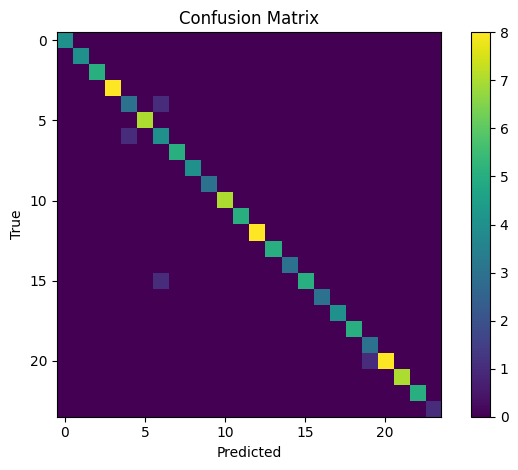

In [21]:
#@title Evaluation on the test set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
def predict_dataset(ds):
    out = trainer.predict(ds)
    logits = out.predictions
    y_true = out.label_ids
    y_pred = logits.argmax(-1)
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    return y_true, y_pred, probs

y_true, y_pred, probs = predict_dataset(test_ds)
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Test Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f}")
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(labels))]))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


In [22]:
#@title Optional: Selective prediction (entropy threshold)
import numpy as np

def entropy(p, axis=-1, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -(p * np.log(p)).sum(axis=axis)

val_true, val_pred, val_probs = predict_dataset(val_ds)
val_ent = entropy(val_probs)

# Choose threshold that maximizes accuracy on accepted predictions with >= 70% coverage
target_coverage = 0.7
ths = np.quantile(val_ent, np.linspace(0.0, 1.0, 101))
best_thr, best_acc, best_cov = None, -1, 0
for t in ths:
    mask = val_ent <= t
    cov = mask.mean()
    if cov < target_coverage:
        continue
    acc = accuracy_score(val_true[mask], val_pred[mask]) if mask.any() else 0.0
    if acc > best_acc:
        best_thr, best_acc, best_cov = t, acc, cov

if best_thr is None:
    print("Could not find threshold meeting coverage target; using median entropy.")
    best_thr = float(np.median(val_ent))
    best_cov = float((val_ent <= best_thr).mean())
    best_acc = accuracy_score(val_true[val_ent <= best_thr], val_pred[val_ent <= best_thr]) if (val_ent <= best_thr).any() else 0.0

print(f"Selected entropy threshold: {best_thr:.4f} | Val coverage: {best_cov:.3f} | Val accepted accuracy: {best_acc:.3f}")

test_true, test_pred, test_probs = y_true, y_pred, probs
test_ent = entropy(test_probs)
mask = test_ent <= best_thr
acc_acc = accuracy_score(test_true[mask], test_pred[mask]) if mask.any() else 0.0
print(f"Test accepted coverage: {mask.mean():.3f} | Test accepted accuracy: {acc_acc:.3f}")


Selected entropy threshold: 0.4235 | Val coverage: 0.700 | Val accepted accuracy: 1.000
Test accepted coverage: 0.683 | Test accepted accuracy: 1.000


In [23]:
#@title Save model, tokenizer, labels, cues; demo inference
save_dir = "artifacts/model_final"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)
tok.save_pretrained(save_dir)

with open(os.path.join(save_dir, "labels.json"), "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f)

# Copy cues file
import shutil
shutil.copy("artifacts/class_cues.json", os.path.join(save_dir, "class_cues.json"))

print("Saved to:", save_dir)

# 🔎 Inference helper
clf = AutoModelForSequenceClassification.from_pretrained(save_dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_dir)

def predict_text(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        out = clf(**enc)
        probs = torch.softmax(out.logits, dim=-1).squeeze(0).cpu().numpy()
    d = int(probs.argmax())
    return id2label[d], float(probs[d])

# Demo
demo_text = "itchy scaly plaques on elbows and knees for months, no fever"
pred, conf = predict_text(demo_text)
print("Demo:", demo_text)
print("Predicted:", pred, "| confidence:", f"{conf:.3f}")


Saved to: artifacts/model_final
Demo: itchy scaly plaques on elbows and knees for months, no fever
Predicted: Psoriasis | confidence: 0.561


In [27]:
import ipywidgets as w
from IPython.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity


def predict_all(text, k=5):

    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        out = clf(**enc)
        probs = torch.softmax(out.logits, dim=-1).squeeze(0).cpu().numpy()

    # Get top k predictions
    topk_indices = np.argsort(-probs)[:k]
    ranked_labels = [(id2label[i], probs[i]) for i in topk_indices]

    return ranked_labels

symptoms = w.Textarea(
    value="",
    placeholder="e.g., high fever, severe headache, muscle/joint pain, rash",
    description="Symptoms:",
    layout=w.Layout(width="100%", height="110px")
)
btn_predict = w.Button(description="Predict", button_style="primary")
btn_clear = w.Button(description="Clear")
out = w.Output()

def on_predict(_):
    with out:
        out.clear_output()
        text = (symptoms.value or "").strip()
        if not text:
            display(HTML("<b>Please type symptoms.</b>"))
            return
        ranked = predict_all(text)
        top_label, top_prob = ranked[0]
        display(HTML(
            f"<h3>Predicted disease: {top_label}</h3>"
            f"<p><b>Probability:</b> {top_prob:.2%}</p>"
            "<p style='color:#666'>Research prototype — not medical advice.</p>"
        ))
        if len(ranked) > 1:
            display(HTML("<h4>Other potential diagnoses:</h4>"))
            for label, prob in ranked[1:]:
                display(HTML(f"<p>{label}: {prob:.2%}</p>"))


def on_clear(_):
    with out:
        out.clear_output()
    symptoms.value = ""

btn_predict.on_click(on_predict)
btn_clear.on_click(on_clear)

display(w.VBox([
    w.HTML("<h2> Symptom → Disease</h2>"),
    symptoms,
    w.HBox([btn_predict, btn_clear]),
    out
]))

on_predict(None)